# Problem 1:
Predict the burned area of forest fires with neural networks.

## 1. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.decomposition import PCA # Reduce dimensions of dataset for plots.

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation, Layer, Lambda, Dropout

from scikeras.wrappers import KerasClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_score, recall_score, roc_auc_score, roc_curve

In [2]:
#!pip install scikeras

In [3]:
%matplotlib notebook

## 2. Load dataset

In [4]:
forest_df = pd.read_csv('forestfires.csv')

In [5]:
forest_df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


## 3. EDA
### 3.1 Data understanding

In [6]:
forest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  dayfri         517 non-null    int64  
 12  daymon         517 non-null    int64  
 13  daysat         517 non-null    int64  
 14  daysun         517 non-null    int64  
 15  daythu         517 non-null    int64  
 16  daytue         517 non-null    int64  
 17  daywed         517 non-null    int64  
 18  monthapr  

### 3.2 Separating data into features and target

In [7]:
# Extracting column names and sorting them to appropriate categories.
def column_segregator(df, y_name=None):
    """ Returns  three lists of column headers for feature columns, 
    numeric columns and categorical columns
    Input
    ------
    df: Dataframe
    y_name: default None. Name(str) of target column if available
    
    Output
    ------
    features, numeric_cols, cat_cols"""   
    
    cols = df.columns # List of all columns in the input dataframe.
    numeric_cols = [col for col in cols if (df[col].dtypes != 'object') and col != y_name]
    cat_cols = [col for col in cols if (df[col].dtypes == 'object') and col != y_name]
    features = [col for col in cols if col != y_name]
    
    return features, numeric_cols, cat_cols 

In [8]:
def Xy_split(df, y_name=None, y_col=True):
    """Splits the input dataframe into features and target
    input
    -----
    df: Input dataframe
    y_name: default None. Name(str) of target column if available
    y_col: 'True' if y column is present in input dataframe, else 'False'.
    
    output
    ------
    X (features) , y (target) if y colum is present else only X"""
    
    target = y_name
    feature_col,_,_ = column_segregator(df, target)
    if y_col == True:
        # separating features and target.
        X = df.loc[:, feature_col]
        y = df.loc[:, target]
        return X,y
    else:
        X = df.loc[:, feature_col]
        return X

In [9]:
# Column segregation.
features, numeric_cols, cat_cols = column_segregator(forest_df, y_name='size_category')

In [10]:
X, y = Xy_split(forest_df, y_name='size_category', y_col=True)

In [11]:
X[numeric_cols].head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,...,0,0,0,0,0,1,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,...,0,0,0,0,0,1,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0


### 3.3 Visualizations:

#### 3.3.1 Feature distribution - numeric features

<IPython.core.display.Javascript object>


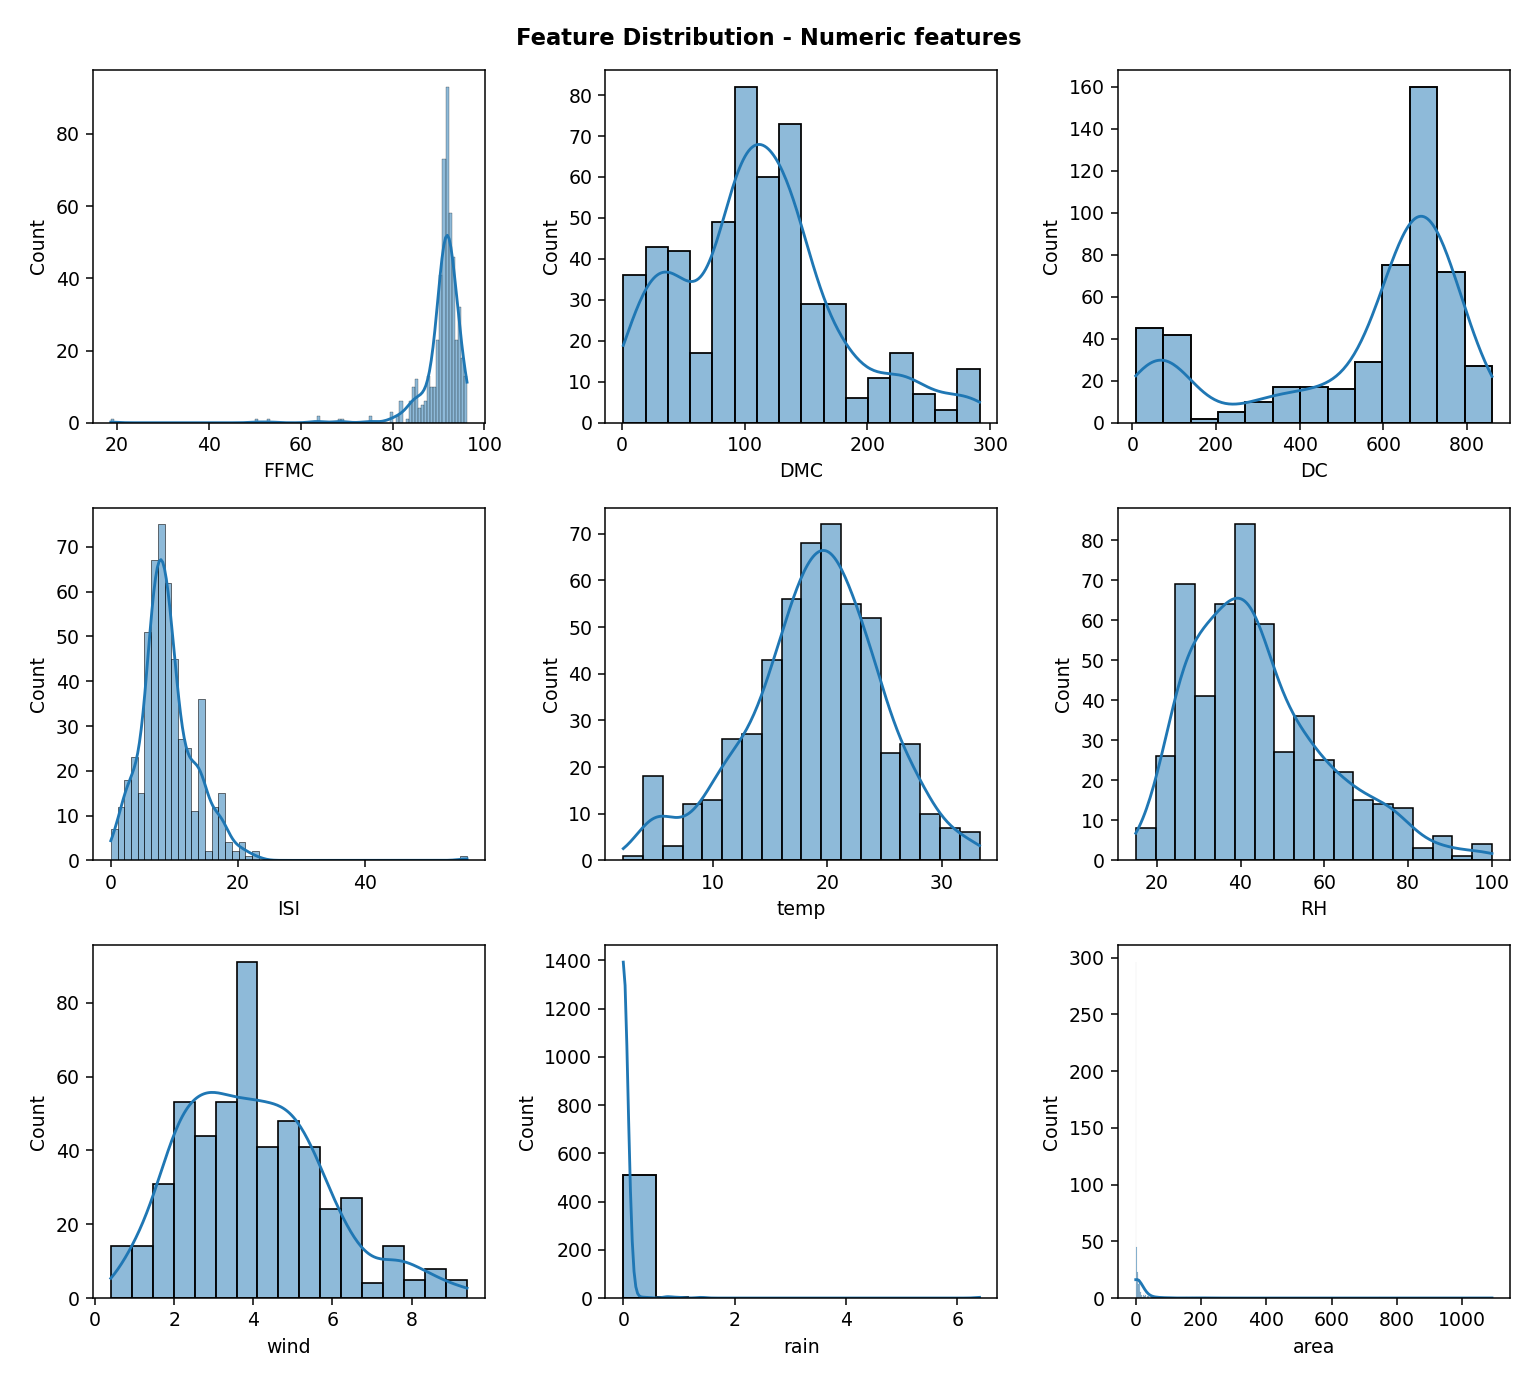

In [12]:
fig, axes = plt.subplots(3,3, figsize=(10,9))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.histplot(data=X, x=X[numeric_cols[idx]], ax=ax, kde=True)

fig.suptitle('Feature Distribution - Numeric features', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

#### 3.3.2 Feature distribution - categorical features

<IPython.core.display.Javascript object>


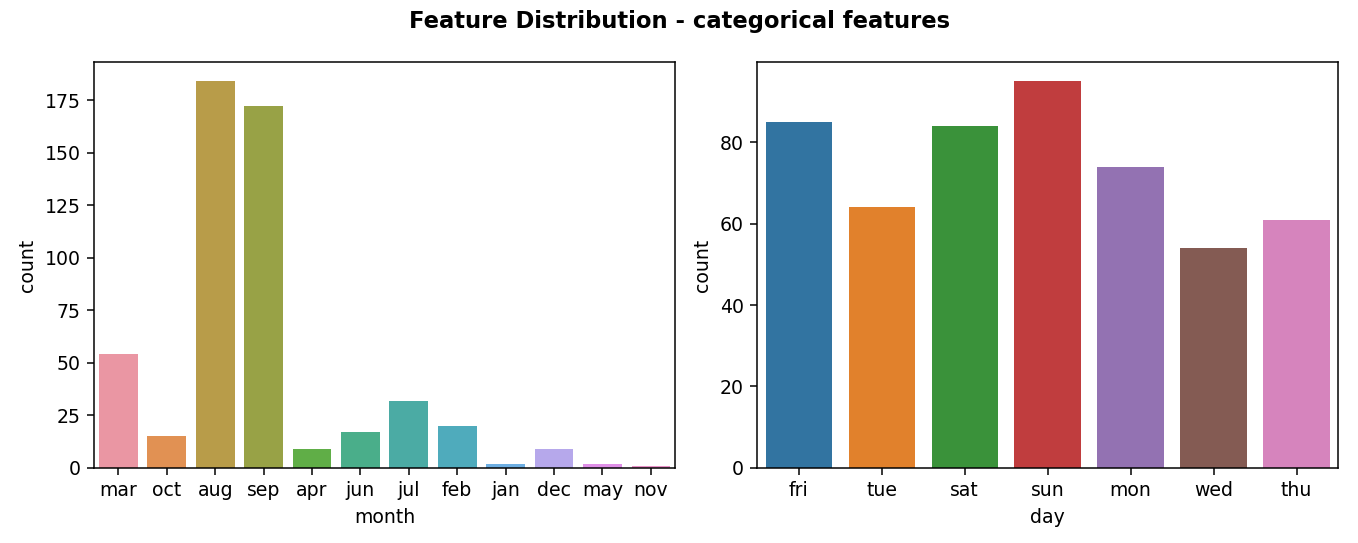

In [13]:
fig, axes = plt.subplots(1,2, figsize=(10,4))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.countplot(data=X, x=X[cat_cols[idx]], ax=ax)

fig.suptitle('Feature Distribution - categorical features', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

#### 3.3.3 Target distribution 

<IPython.core.display.Javascript object>


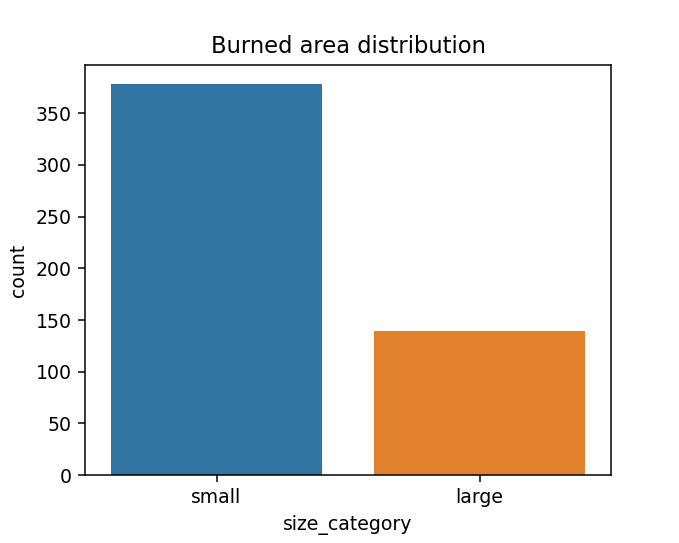

In [14]:
fig, ax = plt.subplots(figsize=(5,4))
sns.countplot(x=y, ax=ax) 
ax.set_xlabel('size_category')
ax.set_title('Burned area distribution')
plt.show()

In [15]:
X_1 = X.drop(cat_cols, axis=1)

In [16]:
X_1.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,dayfri,...,monthdec,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep
0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1,...,0,0,0,0,0,1,0,0,0,0
1,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,0,...,0,0,0,0,0,0,0,0,1,0
3,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1,...,0,0,0,0,0,1,0,0,0,0
4,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
y_1 = y.apply(lambda x: 0 if(x=='small') else 1)

#### 3.3.5 Heatmap - to find correlations

<IPython.core.display.Javascript object>


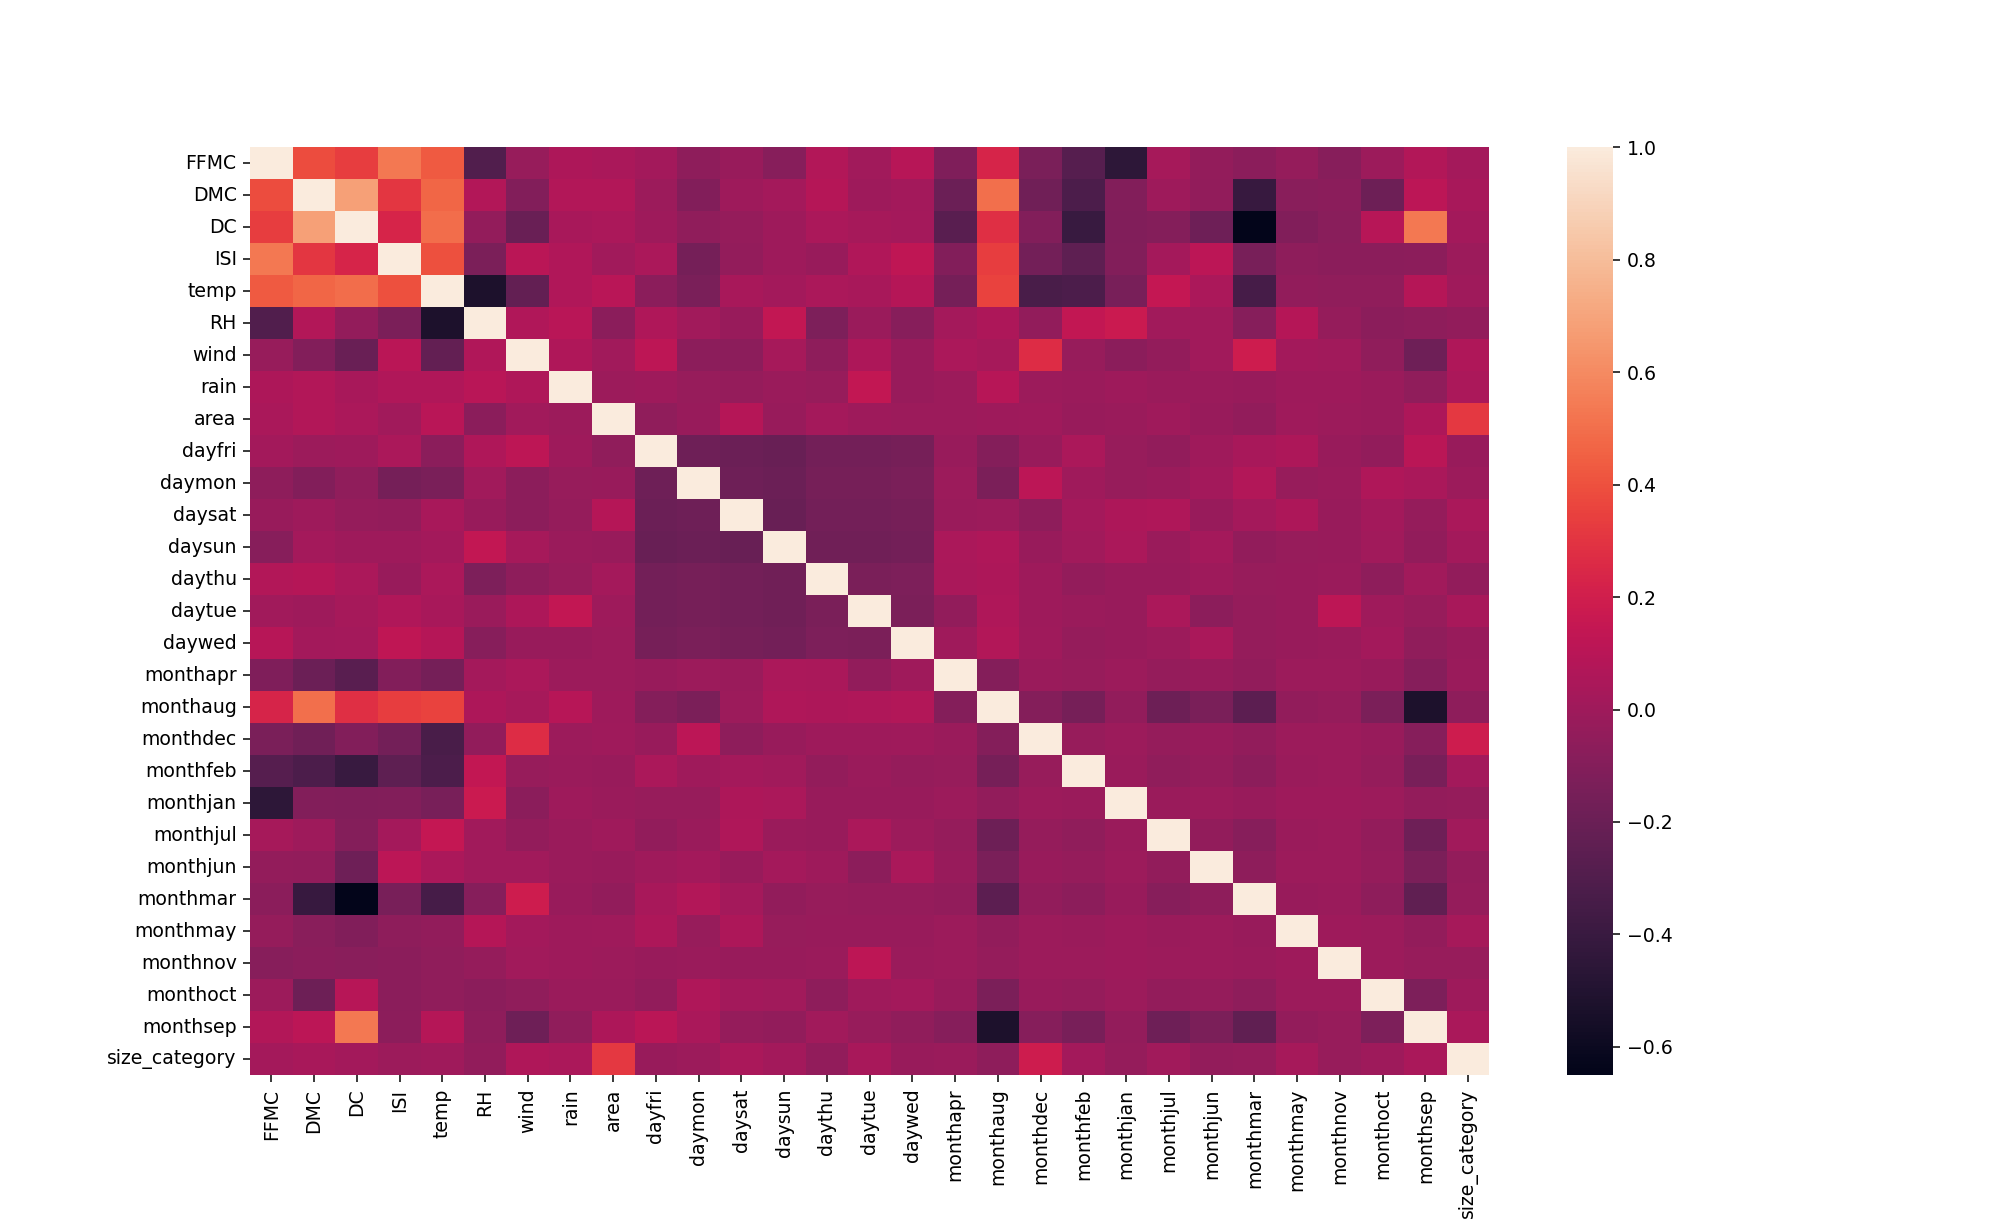

In [18]:
df_heatmap = pd.concat([X_1,y_1], axis=1)
fig, ax = plt.subplots(figsize=(13,8))
sns.heatmap(df_heatmap.corr(), ax=ax, annot=False)
plt.show()

#### 3.3.6 Plotting the output labels as clusters:

In [19]:
def cluster_visualization(df_sc, labels): # label = y_hc
    # PCA -> N-D to 2D for scatterplot.
    pca = PCA(2)
    df_pca = pca.fit_transform(df_sc)
    u_labels = np.unique(labels)
    
    # Plotting
    fig, ax = plt.subplots()
    for i in u_labels:
        ax.scatter(df_pca[labels == i, 0], df_pca[labels == i, 1], label = i)

    ax.legend()

In [20]:
scaler =MinMaxScaler()
X_1sc = scaler.fit_transform(X_1) #.iloc[:, :8]

<IPython.core.display.Javascript object>


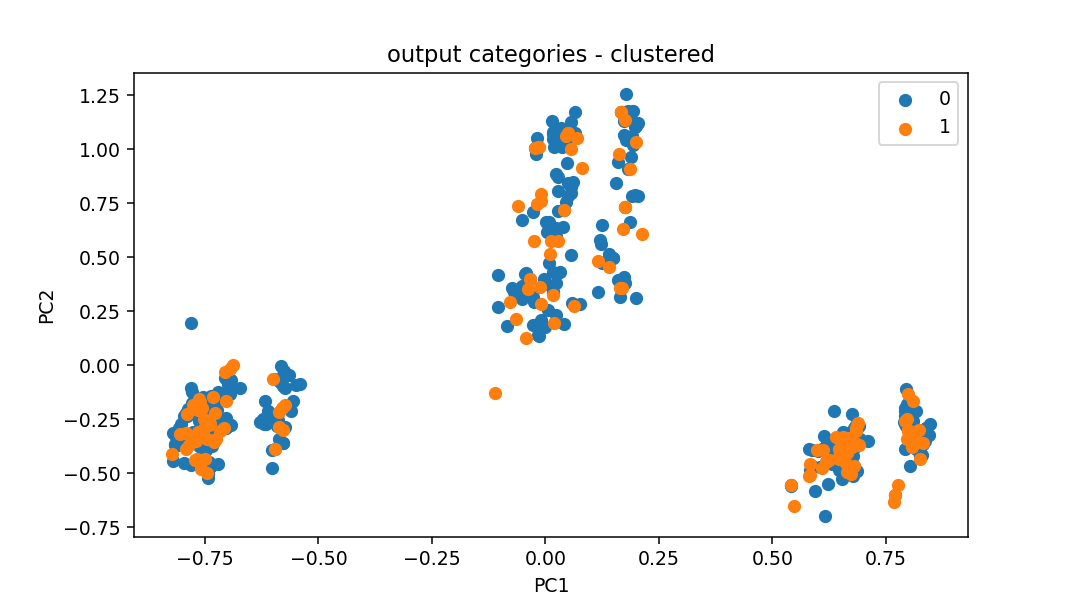

In [21]:
cluster_visualization(X_1sc, y_1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('output categories - clustered')
plt.show()

### 3.4 Observations:
- 517 records, 30 feature columns and one target column.
- 11 features in total. We remove 'month' and 'day' columns since they are one hot encoded already in the dataset.
- No null values, all features have correct datatypes.
- Not all numeric features are normally distributed.
- Only the 'day' feature has a uniform distribution, 'month' feature is non uniform.
- Output distribution is not balanced.
- From the heatmap, we can see some strong negative correlations and some strong positive correlations.
- From the clusters, we see that it is hard to differentiate between the 0 and 1 class ('small and 'large') i.e it is hard to draw a a clear boundary between the two clusters. Thus the data is nonlinear and we must use a nonlinear activation function while training the neural network.

## 4. Model Building

### 4.1 Baseline model

In [22]:
tf.random.set_seed(42) # TO ensure consistency in results.

In [23]:
def baseline_model():
    # Create model
    model = Sequential()
    model.add(Dense(42, input_dim=28, activation='relu'))# defining the input or visible layer and the first hidden layer.
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [24]:
# Evaluate model (without any further preprocessing)
estimator = KerasClassifier(model=baseline_model, epochs=100, batch_size=5, verbose=0)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X_1, y_1, cv=kfold, scoring='accuracy')
print('Baseline model accuracy: {:.2f}'.format(results.mean()))

Baseline model accuracy: 0.96


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42, stratify=y_1)

In [26]:
estimator.fit(X_train, y_train)

KerasClassifier(
	model=<function baseline_model at 0x00000207F82535E8>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=5
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=100
	class_weight=None
)

### 4.2 Baseline model evaluation

In [27]:
y_pred_bl = pd.Series(estimator.predict(X_test), index=y_test.index)

In [28]:
def display_results(y_test, y_pred):
    """Displays model evaluation/performance report that includes
    accuracy_score, confusion_matrix, precision_score, and 
    recall_score.
    input
    -----
    y_test, y_pred
    
    output
    ------
    Model evaluation/performance report"""
    
    print(classification_report(y_test, y_pred))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

In [29]:
display_results(y_test, y_pred_bl)

              precision    recall  f1-score   support

           0       0.99      0.96      0.97        76
           1       0.90      0.96      0.93        28

    accuracy                           0.96       104
   macro avg       0.94      0.96      0.95       104
weighted avg       0.96      0.96      0.96       104

Confusion matrix:
 [[73  3]
 [ 1 27]]


## 5. Improving the model

### 5.1 Model 1 
**updates:** Baseline and Standardization

In [30]:
# Cross validation with standardization
def cross_validator(Xdf, ydf, model, epochs, batch_size, scaler=None, n_splits=10, verbose=0):
    estimators = []
    if scaler != None:
        estimators.append(('scaler', scaler))
    estimators.append(('mlp', KerasClassifier(model=model, epochs=epochs, batch_size=batch_size, verbose=verbose)))
    pipeline = Pipeline(estimators)
    kfold = KFold(n_splits=n_splits)
    results = cross_val_score(pipeline, X=Xdf, y=ydf, cv=kfold, scoring='accuracy')
    print('Model accuracy: {:.2f}'.format(results.mean()))

In [31]:
cross_validator(Xdf=X_1,
                ydf=y_1,
                model=baseline_model,
                scaler=StandardScaler(),
                epochs=100,
                batch_size=5, 
                n_splits=10, 
                verbose=0)

Model accuracy: 0.92


In [32]:
def model_tester(Xdf, ydf, model, epochs, batch_size, scaler=None, verbose=0):
    test_estimators = []
    if scaler != None:
        test_estimators.append(('scaler', scaler))
    test_estimators.append(('mlp',KerasClassifier(model=model, epochs=epochs, batch_size=batch_size, verbose=verbose)))
    test_model = Pipeline(test_estimators)
    test_model.fit(Xdf, ydf)
    return test_model

In [33]:
model1 = model_tester(Xdf=X_train,
                      ydf=y_train,
                      model=baseline_model,
                      scaler=StandardScaler(),
                      epochs=100,
                      batch_size=5,
                      verbose=0)

In [34]:
y_pred_m1 = pd.Series(model1.predict(X_test), index=y_test.index)

In [35]:
display_results(y_test, y_pred_m1)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94        76
           1       0.95      0.68      0.79        28

    accuracy                           0.90       104
   macro avg       0.92      0.83      0.86       104
weighted avg       0.91      0.90      0.90       104

Confusion matrix:
 [[75  1]
 [ 9 19]]


### Observations:
- Standardization is causing the scores to go down.

### 5.2 Model 2 
**updates:** Experimenting with a denser model 

In [36]:
# Define a larger model than baseline with additional neurons:
def larger_model():
    # Create model
    model = Sequential()
    model.add(Dense(42, input_dim=28, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [37]:
cross_validator(Xdf=X_1,
                ydf=y_1,
                model=larger_model,
                scaler=None,
                epochs=50,
                batch_size=5, 
                n_splits=10, 
                verbose=0)

Model accuracy: 0.97


In [38]:
model2 = model_tester(Xdf=X_train,
                      ydf=y_train,
                      model=larger_model,
                      scaler=None,
                      epochs=100,
                      batch_size=5,
                      verbose=0)

In [39]:
y_pred_m2 = pd.Series(model1.predict(X_test), index=y_test.index)

In [40]:
display_results(y_test, y_pred_m2)

              precision    recall  f1-score   support

           0       0.89      0.99      0.94        76
           1       0.95      0.68      0.79        28

    accuracy                           0.90       104
   macro avg       0.92      0.83      0.86       104
weighted avg       0.91      0.90      0.90       104

Confusion matrix:
 [[75  1]
 [ 9 19]]


### 5.3 Model 3 
**Updates:** Wider network

In [41]:
# Define a larger model than baseline with additional neurons:
def wider_model():
    # Create model
    model = Sequential()
    model.add(Dense(126, input_dim=28, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [42]:
cross_validator(Xdf=X_1,
                ydf=y_1,
                model=wider_model,
                scaler=None,
                epochs=50,
                batch_size=5, 
                n_splits=10, 
                verbose=0)

Model accuracy: 0.98


In [43]:
model3 = model_tester(Xdf=X_train,
                      ydf=y_train,
                      model=wider_model,
                      scaler=None,
                      epochs=100,
                      batch_size=5,
                      verbose=0)

In [44]:
y_pred_m3 = pd.Series(model3.predict(X_test), index=y_test.index)

In [45]:
display_results(y_test, y_pred_m3)

              precision    recall  f1-score   support

           0       0.98      0.86      0.92        76
           1       0.71      0.96      0.82        28

    accuracy                           0.88       104
   macro avg       0.85      0.91      0.87       104
weighted avg       0.91      0.88      0.89       104

Confusion matrix:
 [[65 11]
 [ 1 27]]


### 5.4 Model 4:
**Updates:** Denser network with dropout layers.

In [46]:
def larger_model_1():
    # Create model
    model = Sequential()
    model.add(Dense(42, input_dim=28, activation='relu'))
    model.add(Dense(30, activation='swish'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [47]:
cross_validator(Xdf=X_1,
                ydf=y_1,
                model=larger_model_1,
                scaler=None,
                epochs=50,
                batch_size=5, 
                n_splits=10, 
                verbose=0)

Model accuracy: 0.98


In [48]:
model4 = model_tester(Xdf=X_train,
                      ydf=y_train,
                      model=larger_model_1,
                      scaler=None,
                      epochs=100,
                      batch_size=5,
                      verbose=0)

In [49]:
y_pred_m4 = pd.Series(model4.predict(X_test), index=y_test.index)

In [50]:
display_results(y_test, y_pred_m4)

              precision    recall  f1-score   support

           0       0.99      0.91      0.95        76
           1       0.79      0.96      0.87        28

    accuracy                           0.92       104
   macro avg       0.89      0.94      0.91       104
weighted avg       0.93      0.92      0.93       104

Confusion matrix:
 [[69  7]
 [ 1 27]]


### 5.5 Model 5
**Updates:** Wider network with dropout.

In [51]:
# Define a larger model than baseline with additional neurons:
def wider_model_1():
    # Create model
    model = Sequential()
    model.add(Dense(126, input_dim=28, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [52]:
cross_validator(Xdf=X_1,
                ydf=y_1,
                model=wider_model_1,
                scaler=None,
                epochs=50,
                batch_size=5, 
                n_splits=10, 
                verbose=0)

Model accuracy: 0.95


In [53]:
model5 = model_tester(Xdf=X_train,
                      ydf=y_train,
                      model=wider_model_1,
                      scaler=None,
                      epochs=100,
                      batch_size=5,
                      verbose=0)

In [54]:
y_pred_m5 = pd.Series(model5.predict(X_test), index=y_test.index)

In [55]:
display_results(y_test, y_pred_m5)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        76
           1       1.00      0.89      0.94        28

    accuracy                           0.97       104
   macro avg       0.98      0.95      0.96       104
weighted avg       0.97      0.97      0.97       104

Confusion matrix:
 [[76  0]
 [ 3 25]]


### 5.6 Model - 6
**Updates:** Using 'swish' Instead of 'relu' as activation function, with a dropout of 0.5.

In [56]:
# Define a larger model than baseline with additional neurons:
def wider_model_2():
    # Create model
    model = Sequential()
    model.add(Dense(126, input_dim=28, activation='swish'))
    model.add(Dropout(0.5))
    #model.add(Dense(126, activation='swish'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [57]:
cross_validator(Xdf=X_1,
                ydf=y_1,
                model=wider_model_2,
                scaler=None,
                epochs=50,
                batch_size=5, 
                n_splits=10, 
                verbose=0)

Model accuracy: 0.97


In [58]:
model6 = model_tester(Xdf=X_train,
                      ydf=y_train,
                      model=wider_model_2,
                      scaler=None,
                      epochs=100,
                      batch_size=5,
                      verbose=0)

In [59]:
y_pred_m6 = pd.Series(model6.predict(X_test), index=y_test.index)

In [60]:
display_results(y_test, y_pred_m6)

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        76
           1       1.00      0.93      0.96        28

    accuracy                           0.98       104
   macro avg       0.99      0.96      0.97       104
weighted avg       0.98      0.98      0.98       104

Confusion matrix:
 [[76  0]
 [ 2 26]]


### 5.7 Model-7
**Updates:** Adding another dense layer with swish, since from previous, we see it was improving the classification for the 1 class.

In [61]:
# Define a larger model than baseline with additional neurons:
def larger_model_2():
    # Create model
    model = Sequential()
    model.add(Dense(126, input_dim=28, activation='swish'))
    model.add(Dropout(0.5))
    model.add(Dense(126, activation='swish'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [62]:
cross_validator(Xdf=X_1,
                ydf=y_1,
                model=larger_model_2,
                scaler=None,
                epochs=50,
                batch_size=5, 
                n_splits=10, 
                verbose=0)

Model accuracy: 0.90


In [63]:
model7 = model_tester(Xdf=X_train,
                      ydf=y_train,
                      model=larger_model_2,
                      scaler=None,
                      epochs=100,
                      batch_size=5,
                      verbose=0)

In [64]:
y_pred_m7 = pd.Series(model7.predict(X_test), index=y_test.index)

In [65]:
display_results(y_test, y_pred_m7)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        76
           1       0.97      1.00      0.98        28

    accuracy                           0.99       104
   macro avg       0.98      0.99      0.99       104
weighted avg       0.99      0.99      0.99       104

Confusion matrix:
 [[75  1]
 [ 0 28]]


### 5.8 Observations:
- There is an asymmetry in the dataset i.e there are fewer instances of 1 class compared to 0-class. Due to this we can expect high accuracies but misclassifications for the 1 class.
- Although we get a very high accuracy from the baseline model, upon condstructing the confusion matrix, we see that there is a misclassification for the 1-class. It may be that the baseline model is overfitting or it may be a good model. For verification we construct different models with diffferent network densities.
- We can see that upon incremental adjustments to the baseline model, we can reduce the misclassifications for the 1-class which is the objective of the model i.e to correctly predict the size of the burnt area of forests.
- From the analysis, we can either choose the baseline model itself or the much denser 'Model 7' with dropout layers. This model seems to have very high recall scores for the 1-class. 
- Model 7 will be used for the final analysis.

## 6. Final evaluation 

### 6.1 ROC Curve - Test data

AUC: 0.9934210526315789


<IPython.core.display.Javascript object>


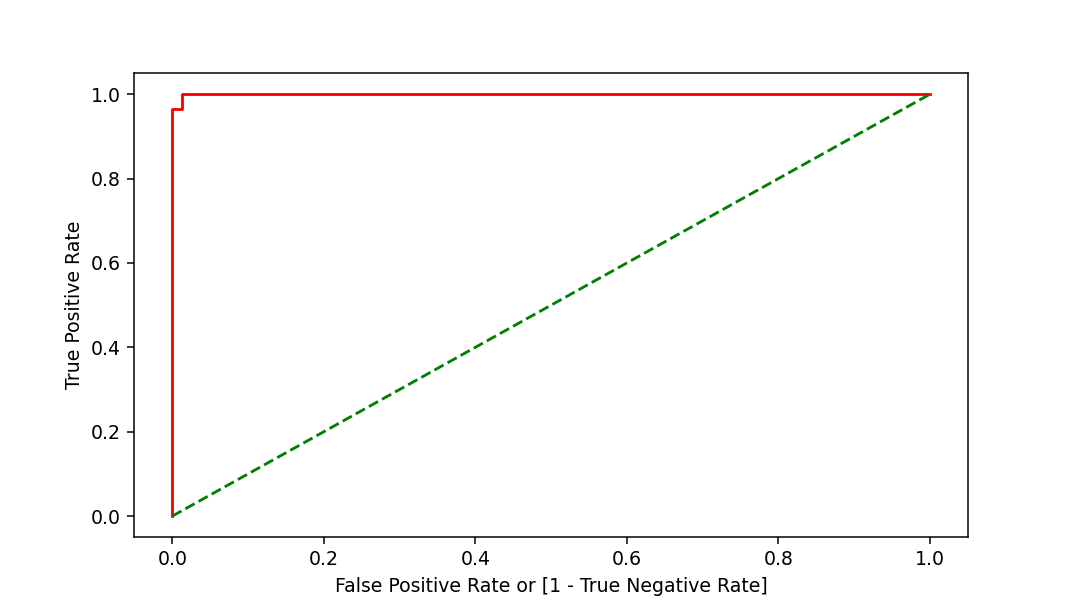

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, model7.predict_proba(X_test)[:,1])

auc = roc_auc_score(y_test, y_pred_m7)
print("AUC:",auc)

fig,ax = plt.subplots()
ax.plot(fpr, tpr, color='red', label='logit model ( area  = %0.2f)'%auc)
ax.plot([0, 1], [0, 1], 'g--')
ax.set_xlabel('False Positive Rate or [1 - True Negative Rate]')
ax.set_ylabel('True Positive Rate')
plt.show()



### 6.2 Predictions for the full dataset and corresponding ROC-AUC curve

In [67]:
y_pred_full = pd.Series(model7.predict(X_1), index=y_1.index)

In [68]:
display_results(y_1, y_pred_full)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       378
           1       0.93      1.00      0.97       139

    accuracy                           0.98       517
   macro avg       0.97      0.99      0.98       517
weighted avg       0.98      0.98      0.98       517

Confusion matrix:
 [[368  10]
 [  0 139]]


AUC: 0.9867724867724867


<IPython.core.display.Javascript object>


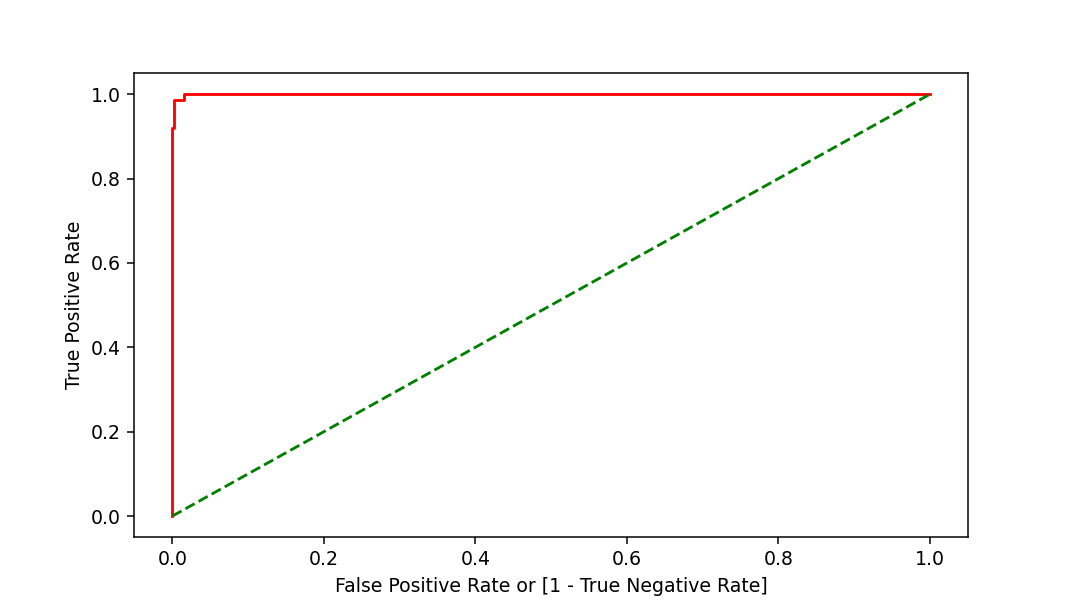

In [69]:
fpr, tpr, thresholds = roc_curve(y_1, model7.predict_proba(X_1)[:,1])

auc = roc_auc_score(y_1, y_pred_full)
print("AUC:",auc)

fig,ax = plt.subplots()
ax.plot(fpr, tpr, color='red', label='logit model ( area  = %0.2f)'%auc)
ax.plot([0, 1], [0, 1], 'g--')
ax.set_xlabel('False Positive Rate or [1 - True Negative Rate]')
ax.set_ylabel('True Positive Rate')
plt.show()

## 7. Conclusions
- Although the accuracy is very high, the real test of the model's performance will be with unseen data. As of now, a neural network was constructed to predict the size of the burnt area of forests. It was found that the neural network is **able to correctly classsify all of the cases where the burnt area is large**, and classify the cases where the burnt area is small to a very high accuracy(few misclassifications). This is ok. Even if we misclassify the burnt area as large, we can take extra care to preserve the forest or take actions that would help re-grow the forests.